In [1]:
import pandas as pd
import glob

file_list = sorted(glob.glob("data/tmp_split/subway_copy_part_*.csv"))

subway_copy = pd.DataFrame()

for file in file_list:
    try:
        chunk = pd.read_csv(file, low_memory=False)
        subway_copy = pd.concat([subway_copy, chunk], ignore_index=True)
        print(f"✅ 병합 완료: {file} ({len(chunk):,} rows)")
    except Exception as e:
        print(f"❌ 오류 발생: {file} -> {e}")

print(f"\n🎉 최종 병합 완료: 총 {len(subway_copy):,} rows")


✅ 병합 완료: data/tmp_split\subway_copy_part_1.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_10.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_100.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_101.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_102.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_103.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_104.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_105.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_106.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_107.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_108.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_109.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_11.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_110.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_111.csv (100,000 rows)
✅ 병합 완료: data/tmp_split\subway_copy_part_112

In [3]:
# datetime 기준으로 정렬
subway_copy = subway_copy.sort_values(by='datetime').reset_index(drop=True)

In [4]:
subway_copy

,tm,line,station_number,station_name,direction,stn,TMP,WSD,DAY_PCP,PCP,REH,CHT,congestion,year,month,day,hour,datetime
0,2021010100,1,150,서울역,상선,419,-9.6,3.3,0.0,0.0,NaN,-12.6,0,2021,1,1,0,2021-01-01 00:00:00
1,2021010100,7,2752,온수,상선,423,-7.9,1.3,0.0,0.0,63.2,-7.7,0,2021,1,1,0,2021-01-01 00:00:00
2,2021010100,4,1753,반월,상선,369,-8.9,0.6,0.0,0.0,NaN,-8.6,0,2021,1,1,0,2021-01-01 00:00:00
3,2021010100,7,2752,온수,하선,423,-7.9,1.3,0.0,0.0,63.2,-7.7,0,2021,1,1,0,2021-01-01 00:00:00
4,2021010100,7,2753,까치울,상선,423,-7.9,1.3,0.0,0.0,63.2,-7.7,0,2021,1,1,0,2021-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16369319,2023123123,3,325,옥수,상선,421,1.5,0.6,NaN,NaN,93.5,0.0,20,2023,12,31,23,2023-12-31 23:00:00
16369320,2023123123,6,2637,동묘앞,하선,419,0.9,1.7,4.5,0.0,97.0,-0.2,34,2023,12,31,23,2023-12-31 23:00:00
16369321,2023123123,1,1903,도봉산,하선,406,-1.3,0.1,5.0,0.0,92.0,-0.9,5,2023,12,31,23,2023-12-31 23:00:00
16369322,2023123123,4,1451,경마공원,하선,590,-1.9,0.0,9.5,0.0,99.3,-0.7,28,2023,12,31,23,2023-12-31 23:00:00


In [5]:
subway_2021 = subway_copy[subway_copy['year'] == 2021].copy()
subway_2022 = subway_copy[subway_copy['year'] == 2022].copy()
subway_2023 = subway_copy[subway_copy['year'] == 2023].copy()

In [ ]:
# 1. stn + tm 조합에서 TMP가 존재하는 경우의 평균 계산
avg_tmp_by_stn_tm = (
    subway_2021[subway_2021['TMP'].notna()]
    .groupby(['stn', 'tm'], sort=False)['TMP']
    .mean()
    .reset_index()
    .rename(columns={'TMP': 'TMP_mean'})
)

# 2. TMP가 결측인 행 추출
na_rows = subway_2021['TMP'].isna()

# 3. 결측행만 따로 추출하여 평균값 병합
filled = subway_2021.loc[na_rows].merge(
    avg_tmp_by_stn_tm,
    on=['stn', 'tm'],
    how='left'
)

# 4. TMP_mean이 존재하는 경우에만 TMP 채우기
valid_fill = filled['TMP_mean'].notna()
subway_2021.loc[filled.loc[valid_fill].index, 'TMP'] = filled.loc[valid_fill, 'TMP_mean'].values

print(f"✅ TMP 결측 중 {valid_fill.sum()}건을 stn+tm 기준 TMP 평균값으로 채움 완료")


✅ TMP 결측 중 0건을 stn+tm 기준 TMP 평균값으로 채움 완료


In [12]:
print(subway_2021['TMP'].isna().sum())  # ← 꼭 확인해보세요!

72798


In [14]:
# 결측인 stn+tm 조합
missing_combos = subway_2021[subway_2021['TMP'].isna()][['stn', 'tm']].drop_duplicates()

# 평균값 테이블에 있는 조합과 비교
available_combos = avg_tmp_by_stn_tm[['stn', 'tm']]

# merge로 존재 여부 확인
check = missing_combos.merge(available_combos, on=['stn', 'tm'], how='left', indicator=True)
print(check['_merge'].value_counts())


_merge
left_only     5641
right_only       0
both             0
Name: count, dtype: int64


In [17]:
tmp_na_rows = subway_2021[subway_2021['TMP'].isna()]
print(f"📌 TMP 결측 행 수: {len(tmp_na_rows):,}건")

📌 TMP 결측 행 수: 72,798건


In [18]:
print(tmp_na_rows.head())

              tm  line  station_number station_name direction  stn  TMP  WSD  \
385   2021010100     1            1915          동두천        하선  477  NaN  NaN   
429   2021010100     1            1915          동두천        상선  477  NaN  NaN   
763   2021010101     1            1915          동두천        상선  477  NaN  NaN   
1008  2021010101     1            1915          동두천        하선  477  NaN  NaN   
1533  2021010105     1            1915          동두천        하선  477  NaN  NaN   

      DAY_PCP  PCP  REH   CHT  congestion  year  month  day  hour  \
385       NaN  NaN  NaN -10.8           0  2021      1    1     0   
429       NaN  NaN  NaN -10.8           0  2021      1    1     0   
763       NaN  NaN  NaN -11.5           0  2021      1    1     1   
1008      NaN  NaN  NaN -11.5           0  2021      1    1     1   
1533      NaN  NaN  NaN -13.1           1  2021      1    1     5   

                 datetime  
385   2021-01-01 00:00:00  
429   2021-01-01 00:00:00  
763   2021-01-01 01:

In [26]:
# TMP 결측인 행 복사
subway_2021_tmp_na = subway_2021[subway_2021['TMP'].isna()].copy()

In [27]:
# datetime 형식으로 변환
subway_2021_tmp_na['datetime'] = pd.to_datetime(subway_2021_tmp_na['datetime'])
subway_2021['datetime'] = pd.to_datetime(subway_2021['datetime'])

In [29]:
# 1. stn + tm 조합에서 TMP가 존재하는 경우의 평균 계산
avg_tmp_by_stn_tm = (
    subway_2022[subway_2022['TMP'].notna()]
    .groupby(['stn', 'tm'], sort=False)['TMP']
    .mean()
    .reset_index()
    .rename(columns={'TMP': 'TMP_mean'})
)

# 2. TMP가 결측인 행 추출
na_rows = subway_2022['TMP'].isna()

# 3. 결측행만 따로 추출하여 평균값 병합
filled = subway_2022.loc[na_rows].merge(
    avg_tmp_by_stn_tm,
    on=['stn', 'tm'],
    how='left'
)

# 4. TMP_mean이 존재하는 경우에만 TMP 채우기
valid_fill = filled['TMP_mean'].notna()
subway_2022.loc[filled.loc[valid_fill].index, 'TMP'] = filled.loc[valid_fill, 'TMP_mean'].values

print(f"✅ TMP 결측 중 {valid_fill.sum()}건을 stn+tm 기준 TMP 평균값으로 채움 완료")

✅ TMP 결측 중 0건을 stn+tm 기준 TMP 평균값으로 채움 완료


In [31]:
print(subway_2022['TMP'].isna().sum())  # ← 꼭 확인해보세요!

37922


In [32]:
# TMP 결측인 행 복사
subway_2022_tmp_na = subway_2022[subway_2022['TMP'].isna()].copy()

In [33]:
# datetime 형식으로 변환
subway_2022_tmp_na['datetime'] = pd.to_datetime(subway_2022_tmp_na['datetime'])
subway_2022['datetime'] = pd.to_datetime(subway_2022['datetime'])

In [34]:
subway_2022

,tm,line,station_number,station_name,direction,stn,TMP,WSD,DAY_PCP,PCP,REH,CHT,congestion,year,month,day,hour,datetime
5452143,2022010100,7,2712,도봉산,상선,406,-10.4,0.8,0.0,0.0,56.1,-10.2,0,2022,1,1,0,2022-01-01 00:00:00
5452144,2022010100,1,1903,도봉산,하선,406,-10.4,0.8,0.0,0.0,56.1,-10.2,0,2022,1,1,0,2022-01-01 00:00:00
5452145,2022010100,7,2711,장암,하선,532,-10.3,1.1,0.0,0.0,48.3,-10.5,0,2022,1,1,0,2022-01-01 00:00:00
5452146,2022010100,1,1905,회룡,하선,532,-10.3,1.1,0.0,0.0,48.3,-10.5,1,2022,1,1,0,2022-01-01 00:00:00
5452147,2022010100,7,2711,장암,상선,532,-10.3,1.1,0.0,0.0,48.3,-10.5,0,2022,1,1,0,2022-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848338,2022123123,7,2752,온수,하선,423,-1.5,1.4,0.0,0.0,82.0,-0.2,14,2022,12,31,23,2022-12-31 23:00:00
10848339,2022123123,1,1822,중동,상선,433,-1.0,0.0,0.0,0.0,66.3,-1.2,8,2022,12,31,23,2022-12-31 23:00:00
10848340,2022123123,4,414,수유,하선,424,-1.7,0.9,0.0,0.0,80.8,-1.0,16,2022,12,31,23,2022-12-31 23:00:00
10848341,2022123123,4,411,노원,하선,406,-2.0,0.6,0.0,0.0,88.0,-1.5,15,2022,12,31,23,2022-12-31 23:00:00


In [67]:
stn_groups = {
    "서울북부": [90, 201, 295, 427],
    "서울동부": [276, 294],
    "서울서부": [110, 232, 266],
    "서울중부": [108, 400, 402, 408, 409, 411, 412, 413, 414, 415,
               418, 419, 421, 444, 450, 510, 540, 889],
    "인천": [99, 649, 102, 844, 846],
    "경기북부": [98, 211, 217, 372, 373, 406, 407, 424, 428, 431, 450, 451, 454, 477, 532, 540, 541],
    "경기남부": [119, 202, 203, 212, 369, 435, 572],
    "경기서부": [112, 284, 285, 286, 287, 288,
              410, 423, 425, 433, 434, 437, 438, 545, 565, 590]
}

In [68]:
# 역방향 매핑: stn → 권역
stn_to_region = {stn: region for region, stns in stn_groups.items() for stn in stns}

# 3. subway_2022에 '권역' 컬럼 추가
subway_2022['권역'] = subway_2022['stn'].map(stn_to_region)

In [69]:
# subway_2022에 있는 stn 중, 딕셔너리에 없는 stn 확인
unique_stn = set(subway_2022['stn'].unique())
mapped_stn = set(stn_to_region.keys())

missing_stn = unique_stn - mapped_stn
print("🛑 딕셔너리에 없는 stn 목록:", sorted(missing_stn))

🛑 딕셔너리에 없는 stn 목록: []


In [70]:
# subway_2022에서 고유한 관측소 번호(stn) 리스트 추출
unique_stn_list = sorted(subway_2022['stn'].unique())
print("✅ subway_2022의 고유 stn 목록:", unique_stn_list)

✅ subway_2022의 고유 stn 목록: [98, 108, 110, 112, 369, 372, 373, 400, 402, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 418, 419, 421, 423, 424, 425, 427, 428, 431, 433, 434, 435, 437, 438, 444, 450, 451, 454, 477, 510, 532, 540, 541, 545, 565, 572, 590, 649, 889]


In [72]:
subway_2022.drop(columns=['관측소권역'], inplace=True, errors='ignore')
subway_2022_tmp_na.drop(columns=['관측소권역'], inplace=True, errors='ignore')

In [73]:
subway_2022

,tm,line,station_number,station_name,direction,stn,TMP,WSD,DAY_PCP,PCP,REH,CHT,congestion,year,month,day,hour,datetime,권역
5452143,2022010100,7,2712,도봉산,상선,406,-10.4,0.8,0.0,0.0,56.1,-10.2,0,2022,1,1,0,2022-01-01 00:00:00,경기북부
5452144,2022010100,1,1903,도봉산,하선,406,-10.4,0.8,0.0,0.0,56.1,-10.2,0,2022,1,1,0,2022-01-01 00:00:00,경기북부
5452145,2022010100,7,2711,장암,하선,532,-10.3,1.1,0.0,0.0,48.3,-10.5,0,2022,1,1,0,2022-01-01 00:00:00,경기북부
5452146,2022010100,1,1905,회룡,하선,532,-10.3,1.1,0.0,0.0,48.3,-10.5,1,2022,1,1,0,2022-01-01 00:00:00,경기북부
5452147,2022010100,7,2711,장암,상선,532,-10.3,1.1,0.0,0.0,48.3,-10.5,0,2022,1,1,0,2022-01-01 00:00:00,경기북부
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848338,2022123123,7,2752,온수,하선,423,-1.5,1.4,0.0,0.0,82.0,-0.2,14,2022,12,31,23,2022-12-31 23:00:00,경기서부
10848339,2022123123,1,1822,중동,상선,433,-1.0,0.0,0.0,0.0,66.3,-1.2,8,2022,12,31,23,2022-12-31 23:00:00,경기서부
10848340,2022123123,4,414,수유,하선,424,-1.7,0.9,0.0,0.0,80.8,-1.0,16,2022,12,31,23,2022-12-31 23:00:00,경기북부
10848341,2022123123,4,411,노원,하선,406,-2.0,0.6,0.0,0.0,88.0,-1.5,15,2022,12,31,23,2022-12-31 23:00:00,경기북부


In [ ]:
subway_2022_copy = subway_2022.copy() #subway_2022_copy에 사본 저장해둠

In [78]:
subway_2022 = subway_2022_copy.copy() #subway_2022_copy에 사본 저장해둠

In [ ]:
# station_day_key 생성
subway_2022['station_day_key'] = subway_2022[['station_name', 'year', 'month', 'day']].astype(str).agg('_'.join, axis=1)

# TMP 결측 여부
is_na = subway_2022['TMP'].isna()

# 전체 개수 및 결측 개수
total_counts = subway_2022['station_day_key'].value_counts()
na_counts = subway_2022.loc[is_na, 'station_day_key'].value_counts()

# 결측 비율
na_ratio = na_counts / total_counts

# 100% 결측 키만 추출
fully_missing_keys = na_ratio[na_ratio == 1.0].index

# 문자열 분해
result_df = fully_missing_keys.to_series().str.split('_', expand=True)
result_df.columns = ['역명', 'year', 'month', 'day']
result_df['날짜'] = pd.to_datetime(result_df[['year', 'month', 'day']])

# 최종 출력
print(result_df[['역명', '날짜']])

                  역명         날짜
station_day_key                
간석_2022_10_30     간석 2022-10-30
간석_2022_8_21      간석 2022-08-21
간석_2022_8_3       간석 2022-08-03
고잔_2022_10_21     고잔 2022-10-21
고잔_2022_10_22     고잔 2022-10-22
...              ...        ...
한대앞_2022_6_25    한대앞 2022-06-25
한대앞_2022_6_26    한대앞 2022-06-26
한대앞_2022_6_27    한대앞 2022-06-27
화정_2022_11_15     화정 2022-11-15
화정_2022_11_16     화정 2022-11-16

[327 rows x 2 columns]


In [88]:
# 1. 존재하는 시간만 필터링 (안정성 확보)
valid_hours = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
df = subway_2022[['station_name', 'year', 'month', 'day', 'hour', 'TMP', '권역']].copy()
df = df[df['hour'].isin(valid_hours)]

# 2. 하루 전체 결측 판별용 키
df['station_day_key'] = df[['station_name', 'year', 'month', 'day']].astype(str).agg('_'.join, axis=1)

# 3. value_counts → 결측 비율
total_counts = df['station_day_key'].value_counts()
na_counts = df.loc[df['TMP'].isna(), 'station_day_key'].value_counts()
na_ratio = na_counts / total_counts
fully_missing_keys = na_ratio[na_ratio == 1.0].index

# 4. 보간 대상
fill_mask = df['station_day_key'].isin(fully_missing_keys) & df['TMP'].isna()
fill_rows = df.loc[fill_mask].copy()
fill_rows['원래인덱스'] = fill_rows.index

# 5. 시간별 권역 TMP 평균
region_hour_avg = (
    df[~df['TMP'].isna()]
    .groupby(['권역', 'year', 'month', 'day', 'hour'])['TMP']
    .mean()
    .rename('TMP_avg')
    .reset_index()
)

# 6. merge (정상 시간만 있으므로 시간 누락 없음)
fill_rows = fill_rows.merge(
    region_hour_avg,
    on=['권역', 'year', 'month', 'day', 'hour'],
    how='left'
)

# 7. TMP 보간 반영
df.loc[fill_rows['원래인덱스'], 'TMP'] = fill_rows['TMP_avg'].values
subway_2022['TMP'] = df['TMP']


In [89]:
# 1. 보간된 행만 필터링 (즉, TMP_avg가 존재하고 원래 TMP는 NaN이었던 행)
imputed_rows = fill_rows[fill_rows['TMP_avg'].notna()]

# 2. 보간된 날짜 기준 고유 조합 계산
imputed_days = imputed_rows[['station_name', 'year', 'month', 'day']].drop_duplicates()

# 3. 결과 출력
print(f"✅ 보간된 날짜 수: {len(imputed_days)}일")

✅ 보간된 날짜 수: 312일


In [91]:
na_total = subway_2022['TMP'].isna().sum()
print(f"🔍 현재 TMP 전체 결측치: {na_total:,}건")

🔍 현재 TMP 전체 결측치: 23,434건


In [92]:
most_missing_stations = (
    subway_2022[subway_2022['TMP'].isna()]
    .groupby('station_name')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print(most_missing_stations)

station_name
대야미    698
반월     698
오남     604
진접     604
도봉산    524
노원     524
창동     524
부평     346
백운     346
동암     346
dtype: int64


In [93]:
missing_by_day = (
    subway_2022[subway_2022['TMP'].isna()]
    .groupby(['year', 'month', 'day'])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print(missing_by_day)

year  month  day
2022  6      20     1028
             19      910
      10     27      892
      7      25      652
      8      9       504
      9      10      448
      5      7       444
      6      30      438
      10     18      434
      8      19      418
dtype: int64


In [94]:
# TMP가 결측인 행만 추출
na_rows = subway_2022[subway_2022['TMP'].isna()].copy()

# 역명 + 날짜 단위로 그룹핑하여 결측 건수 확인
na_by_station_day = (
    na_rows.groupby(['station_name', 'year', 'month', 'day'])
    .size()
    .reset_index(name='결측수')
    .sort_values('결측수', ascending=False)
)

# 결과 출력
print(f"📌 TMP 결측치가 가장 많은 역/날짜 TOP 10")
print(na_by_station_day.head(10))

📌 TMP 결측치가 가장 많은 역/날짜 TOP 10
     station_name  year  month  day  결측수
1564          연신내  2022     11   10   76
1086           불광  2022     11   10   76
1562          연신내  2022     10    3   72
1084           불광  2022     10    3   72
378            노원  2022      9   10   64
1922           창동  2022      9   10   64
644           도봉산  2022      9   10   64
1910           창동  2022      5    7   60
366            노원  2022      5    7   60
1141          삼각지  2022      6   30   60


In [95]:
# 연신내 2022년 11월 10일 전체 컬럼 출력
subset = subway_2022[
    (subway_2022['station_name'] == '연신내') &
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 11) &
    (subway_2022['day'] == 10)
]

# 정렬: 시간순 보기 좋게
subset = subset.sort_values(by='hour')

# 결과 확인
print(subset)  # 또는 display(subset) in Jupyter


                  tm  line  station_number station_name direction  stn   TMP  \
10120582  2022111000     3             311          연신내        상선  540   9.8   
10120647  2022111000     6            2615          연신내        하선  540   9.8   
10120680  2022111000     6            2615          연신내        상선  540   9.8   
10121248  2022111000     3             311          연신내        하선  540   9.8   
10121473  2022111001     6            2615          연신내        하선  540  10.5   
...              ...   ...             ...          ...       ...  ...   ...   
10134995  2022111022     6            2615          연신내        상선  540   NaN   
10135255  2022111023     6            2615          연신내        상선  540   NaN   
10135036  2022111023     3             311          연신내        상선  540   NaN   
10135159  2022111023     6            2615          연신내        하선  540   NaN   
10135593  2022111023     3             311          연신내        하선  540   NaN   

          WSD  DAY_PCP  PCP  ...  conge

C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1774330769.py:28: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1774330769.py:28: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1774330769.py:28: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1774330769.py:28: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1774330769.py:28: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1774330769.py:28: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from fon

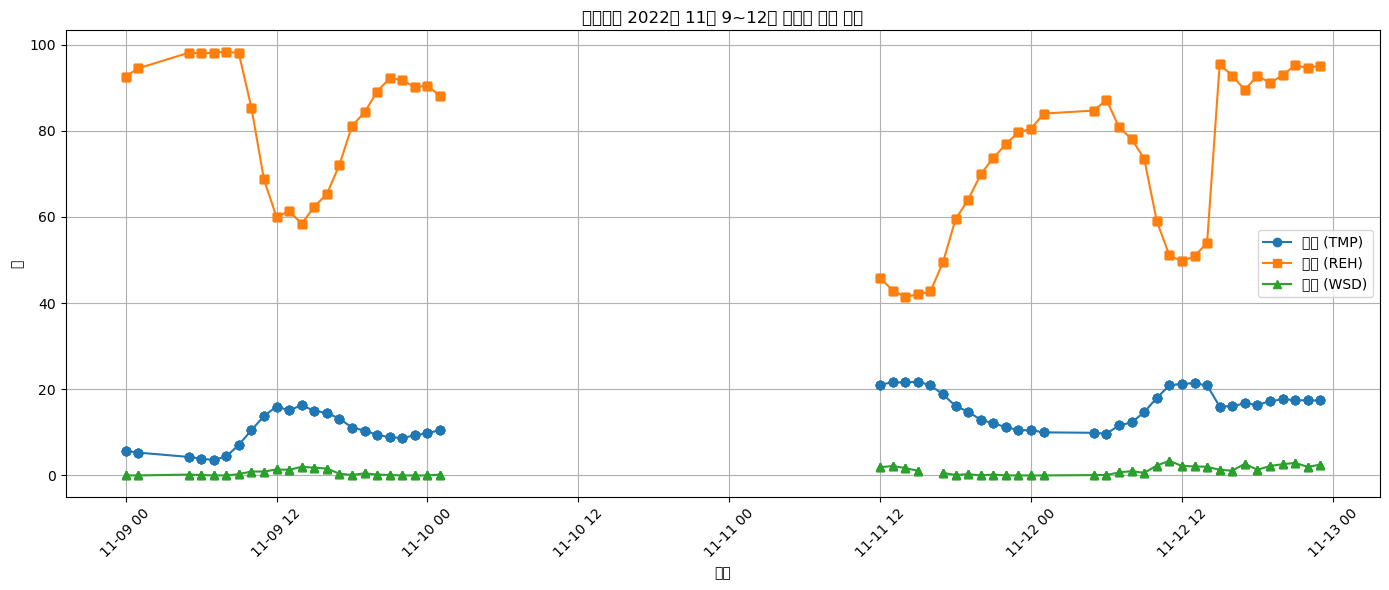

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# 연신내 2022년 11월 9~12일 데이터 필터링
subset = subway_2022[
    (subway_2022['station_name'] == '연신내') &
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 11) &
    (subway_2022['day'].between(9, 12))
].copy()

# datetime 생성 및 정렬
subset['datetime'] = pd.to_datetime(subset[['year', 'month', 'day', 'hour']])
subset = subset.sort_values('datetime')

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(subset['datetime'], subset['TMP'], marker='o', label='기온 (TMP)')
plt.plot(subset['datetime'], subset['REH'], marker='s', label='습도 (REH)')
plt.plot(subset['datetime'], subset['WSD'], marker='^', label='풍속 (WSD)')

plt.title('연신내역 2022년 11월 9~12일 시간별 기상 변수')
plt.xlabel('시간')
plt.ylabel('값')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [100]:
# 1. 연신내가 속한 권역 추출
yeonsinnae_region = subway_2022[subway_2022['station_name'] == '연신내']['권역'].unique()[0]

# 2. 같은 권역의 다른 역 목록
same_region_stations = (
    subway_2022[subway_2022['권역'] == yeonsinnae_region]['station_name']
    .drop_duplicates()
    .sort_values()
)

print(f"✅ 연신내와 같은 권역 ({yeonsinnae_region})에 속한 역 목록:")
print(same_region_stations.tolist())

✅ 연신내와 같은 권역 (경기북부)에 속한 역 목록:
['가능', '공릉', '광운대', '구산', '구파발', '노원', '녹양', '녹천', '당고개', '대곡', '덕계', '덕정', '도봉', '도봉산', '독바위', '동두천', '동두천중앙', '마두', '마들', '망월사', '먹골', '미사', '미아', '방학', '백석', '별내별가람', '보산', '봉화산', '불광', '삼송', '상계', '석계', '소요산', '수락산', '수유', '신내', '쌍문', '양주', '연신내', '오남', '원당', '원흥', '월계', '의정부', '장암', '정발산', '주엽', '중계', '지축', '지행', '진접', '창동', '태릉입구', '하계', '하남풍산', '화랑대', '화정', '회룡']


In [101]:
# 1. 경기북부 권역 데이터만 필터링
gyeonggi_north = subway_2022[subway_2022['권역'] == '경기북부']

# 2. 각 역별 TMP 결측치 개수 계산
missing_counts = gyeonggi_north[gyeonggi_north['TMP'].isna()]['station_name'].value_counts()

# 3. 각 역별 전체 개수에서 결측치 개수를 빼서 "존재하는 TMP 개수" 계산
total_counts = gyeonggi_north['station_name'].value_counts()
available_counts = (total_counts - missing_counts).fillna(0).astype(int)

# 4. TMP 데이터가 가장 많은 역 (결측이 가장 적은 역)
best_station = available_counts.sort_values(ascending=False).head(1)

# 5. 출력
print("✅ 경기북부 권역에서 TMP 결측이 가장 적은 역:")
print(best_station)

✅ 경기북부 권역에서 TMP 결측이 가장 적은 역:
station_name
태릉입구    29476
Name: count, dtype: int32


In [104]:
# 모든 권역별로 반복
regions = subway_2022['권역'].dropna().unique()

fill_total = 0  # 총 보간 건수

for region in regions:
    region_df = subway_2022[subway_2022['권역'] == region]

    # 결측치가 가장 적은 기준역 선택
    tmp_valid_counts = (
        region_df['station_name'].value_counts()
        - region_df[region_df['TMP'].isna()]['station_name'].value_counts()
    ).fillna(0).astype(int)
    
    if tmp_valid_counts.empty:
        continue  # 권역에 유효한 TMP가 없다면 스킵
    
    base_station = tmp_valid_counts.idxmax()

    # 기준역 TMP만 추출
    base_tmp = region_df[
        (region_df['station_name'] == base_station) &
        (~region_df['TMP'].isna())
    ][['year', 'month', 'day', 'hour', 'TMP']].rename(columns={'TMP': 'base_TMP'})

    # 이 권역에서 TMP가 결측인 행
    target_rows = subway_2022.loc[
        (subway_2022['권역'] == region) & (subway_2022['TMP'].isna()),
        ['year', 'month', 'day', 'hour']
    ].copy()
    target_rows['원래인덱스'] = target_rows.index  # 인덱스 보존

    # 기준 TMP와 병합
    merged = target_rows.merge(base_tmp, on=['year', 'month', 'day', 'hour'], how='left')

    # TMP 채우기
    subway_2022.loc[merged['원래인덱스'], 'TMP'] = merged['base_TMP'].values

    # 통계 출력
    filled_count = merged['base_TMP'].notna().sum()
    fill_total += filled_count
    print(f"✅ [{region}] 기준역 '{base_station}' → TMP {filled_count:,}건 보간")

print(f"\n✅ 총 보간 완료: {fill_total:,}건")

✅ [경기북부] 기준역 '노원' → TMP 104건 보간
✅ [서울중부] 기준역 '동대문역사문화공원' → TMP 29,556건 보간
✅ [인천] 기준역 '간석' → TMP 0건 보간
✅ [경기서부] 기준역 '대림' → TMP 17,736건 보간
✅ [경기남부] 기준역 '남위례' → TMP 4,624건 보간
✅ [서울서부] 기준역 '개화산' → TMP 0건 보간
✅ [서울북부] 기준역 '대화' → TMP 0건 보간

✅ 총 보간 완료: 52,020건


In [105]:
na_total = subway_2022['TMP'].isna().sum()
print(f"🔍 현재 TMP 결측치: {na_total:,}건")

🔍 현재 TMP 결측치: 3,940건


In [106]:
# TMP가 결측인 행들 보기
remaining_na = subway_2022[subway_2022['TMP'].isna()]
print(remaining_na[['station_name', 'year', 'month', 'day', 'hour']].drop_duplicates().head(10))

# 가장 많이 남은 역/날짜 TOP 10
print(remaining_na.groupby(['station_name', 'year', 'month', 'day']).size().sort_values(ascending=False).head(10))


        station_name  year  month  day  hour
5929003           마곡  2022      2    2    18
5929059           송정  2022      2    2    18
5929250         김포공항  2022      2    2    18
5929281           방화  2022      2    2    18
5929364           발산  2022      2    2    18
5929367          개화산  2022      2    2    18
5929414          우장산  2022      2    2    18
5929417           화곡  2022      2    2    18
5929728           발산  2022      2    2    19
5929729          우장산  2022      2    2    19
station_name  year  month  day
부개            2022  8      21     42
동암            2022  8      21     42
                           3      42
부평            2022  8      3      42
간석            2022  10     30     42
백운            2022  8      21     42
부개            2022  8      3      42
간석            2022  8      3      42
부평            2022  10     30     42
백운            2022  8      3      42
dtype: int64


In [107]:
subway_2022 = subway_2022[subway_2022['hour'] <= 23]

In [108]:
# 대상 시간
target_dt = (2022, 2, 2, 18)

# 해당 시간대 + 권역 필터링
avg_tmp_candidates = subway_2022[
    (subway_2022['year'] == target_dt[0]) &
    (subway_2022['month'] == target_dt[1]) &
    (subway_2022['day'] == target_dt[2]) &
    (subway_2022['hour'] == target_dt[3]) &
    (subway_2022['권역'].isin(['서울서남', '서울강서'])) &
    (subway_2022['TMP'].notna())
]

# TMP 평균값 계산
avg_tmp_val = avg_tmp_candidates['TMP'].mean()

# 출력
print(f"✅ 2022-02-02 18시, 서울서남/서울강서 TMP 평균: {avg_tmp_val:.2f}℃")

✅ 2022-02-02 18시, 서울서남/서울강서 TMP 평균: nan℃


In [112]:
# 1. 중구 대표역(을지로입구) → 권역 확인
mid_region = subway_2022[subway_2022['station_name'] == '을지로입구']['권역'].unique()[0]

# 2. 중구 권역의 2022-02-02 18시 TMP 평균값 계산
avg_tmp_mid = subway_2022[
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 2) &
    (subway_2022['day'] == 2) &
    (subway_2022['hour'] == 18) &
    (subway_2022['권역'] == mid_region) &
    (subway_2022['TMP'].notna())
]['TMP'].mean()

print(f"📌 중구({mid_region}) 기준 TMP 평균: {avg_tmp_mid:.2f}℃")

# 3. 서울서남/서울강서 18시 TMP 결측 보간
fill_mask = (
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 2) &
    (subway_2022['day'] == 2) &
    (subway_2022['hour'] == 18) &
    (subway_2022['권역'].isin(['서울서남', '서울강서'])) &
    (subway_2022['TMP'].isna())
)

# 4. TMP 보간 적용
subway_2022.loc[fill_mask, 'TMP'] = avg_tmp_mid

# 5. 보간된 건수 출력
print(f"✅ 보간 완료: {fill_mask.sum()}건")


📌 중구(서울중부) 기준 TMP 평균: -1.86℃
✅ 보간 완료: 0건


In [113]:
check_18_na = subway_2022[
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 2) &
    (subway_2022['day'] == 2) &
    (subway_2022['hour'] == 18) &
    (subway_2022['권역'].isin(['서울서남', '서울강서']))
][['station_name', 'hour', 'TMP']]

print(check_18_na)

Empty DataFrame
Columns: [station_name, hour, TMP]
Index: []


In [114]:
# 권역 + 날짜 + 시간 조건에 해당하는 전체 행 확인
debug_check = subway_2022[
    (subway_2022['권역'].isin(['서울서남', '서울강서'])) &
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 2) &
    (subway_2022['day'] == 2)
]

print(debug_check['hour'].value_counts().sort_index())

Series([], Name: count, dtype: int64)


In [115]:
# TMP가 결측인 행만 추출
na_rows = subway_2022[subway_2022['TMP'].isna()].copy()

# 날짜+시간 단위 그룹핑
na_by_datetime = (
    na_rows.groupby(['year', 'month', 'day', 'hour'])
    .size()
    .reset_index(name='결측수')
    .sort_values(by='결측수', ascending=False)
)

# 출력
print(f"🔍 TMP 결측 (날짜+시간 기준) 총 {len(na_by_datetime)}개")
print(na_by_datetime.head(10))  # 상위 10개 보기


🔍 TMP 결측 (날짜+시간 기준) 총 264개
     year  month  day  hour  결측수
172  2022     10   27     7  706
21   2022      6    6    10  178
17   2022      2   28    23   64
0    2022      2    2    18   16
12   2022      2    3     9   16
170  2022     10    3    10   16
171  2022     10   18     5   16
219  2022     11    3    13   16
1    2022      2    2    19   16
15   2022      2    3    12   16


C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1245592137.py:29: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1245592137.py:29: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1245592137.py:29: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1245592137.py:29: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1245592137.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\1245592137.py:29: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) Deja

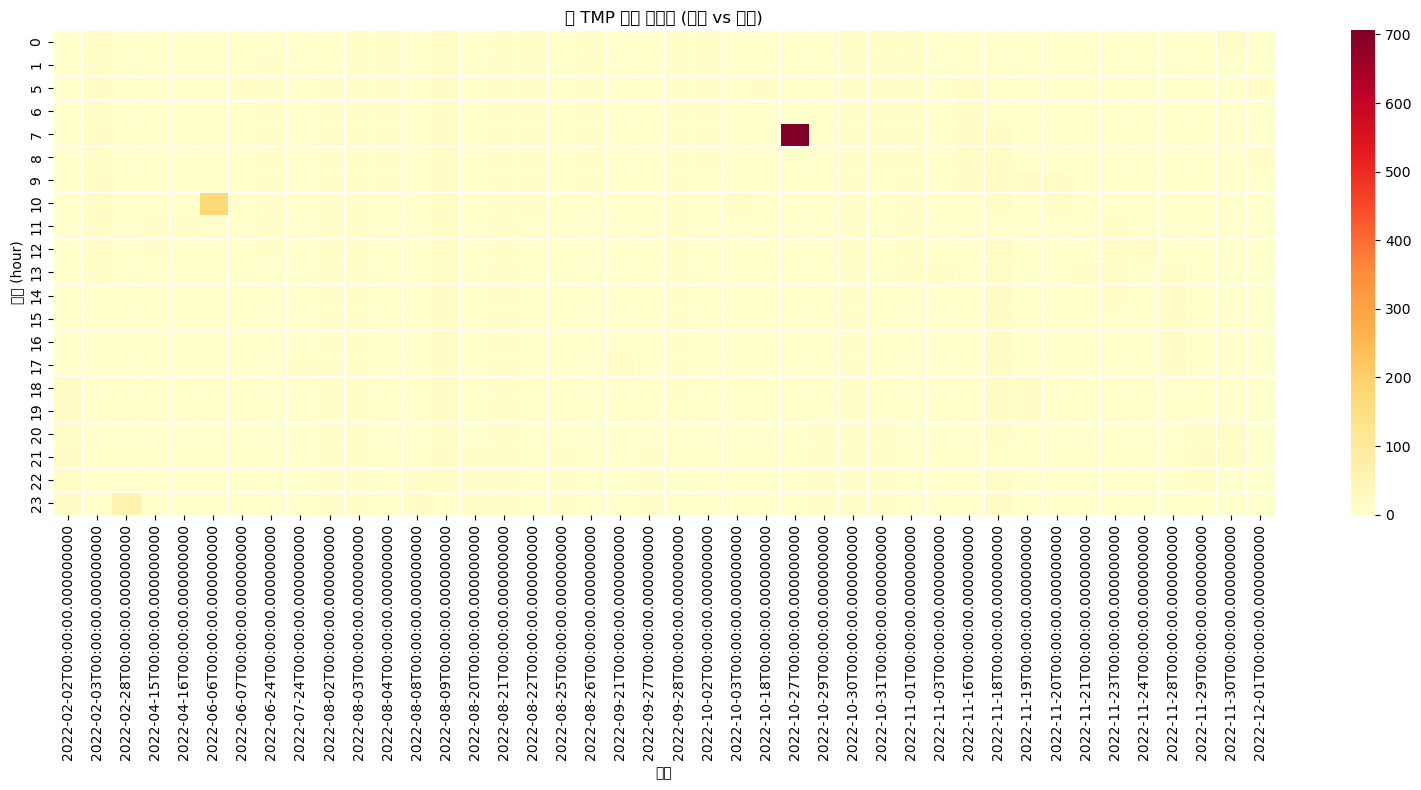

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TMP 결측 행 필터링
na_rows = subway_2022[subway_2022['TMP'].isna()].copy()

# 날짜+시간 단위로 결측 수 계산
na_by_datetime = (
    na_rows.groupby(['year', 'month', 'day', 'hour'])
    .size()
    .reset_index(name='결측수')
)

# 날짜형 컬럼 생성
na_by_datetime['날짜'] = pd.to_datetime(na_by_datetime[['year', 'month', 'day']])

# pivot_table: 시간(세로) × 날짜(가로)
heatmap_data = na_by_datetime.pivot_table(
    index='hour', columns='날짜', values='결측수', fill_value=0
)

# 히트맵 시각화
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5)
plt.title('📊 TMP 결측 히트맵 (날짜 vs 시간)')
plt.xlabel('날짜')
plt.ylabel('시간 (hour)')
plt.tight_layout()
plt.show()


In [117]:
# TMP가 존재하는 행만 필터링
subset = subway_2022[
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 10) &
    (subway_2022['day'] == 27) &
    (subway_2022['hour'] == 7) &
    (subway_2022['TMP'].notna())
]

# TMP 평균값 계산
avg_tmp = subset['TMP'].mean()

print(f"✅ 2022년 10월 27일 07시 TMP 평균: {avg_tmp:.2f}℃")


✅ 2022년 10월 27일 07시 TMP 평균: 6.10℃


In [118]:
# 1. 평균 TMP 계산 (결측 제외)
avg_tmp = subway_2022[
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 10) &
    (subway_2022['day'] == 27) &
    (subway_2022['hour'] == 7) &
    (subway_2022['TMP'].notna())
]['TMP'].mean()

print(f"📌 2022-10-27 07시 TMP 평균값: {avg_tmp:.2f}℃")

# 2. TMP 결측 행 보간 대상 필터링
fill_mask = (
    (subway_2022['year'] == 2022) &
    (subway_2022['month'] == 10) &
    (subway_2022['day'] == 27) &
    (subway_2022['hour'] == 7) &
    (subway_2022['TMP'].isna())
)

# 3. TMP 결측값 평균으로 보간
subway_2022.loc[fill_mask, 'TMP'] = avg_tmp

# 4. 보간된 건수 확인
print(f"✅ 보간 완료: {fill_mask.sum()}건")


📌 2022-10-27 07시 TMP 평균값: 6.10℃
✅ 보간 완료: 706건


In [119]:
# 1. TMP가 결측이 아닌 행 기준으로 날짜+시간별 TMP 평균 계산
tmp_avg_table = subway_2022[
    subway_2022['TMP'].notna()
].groupby(['year', 'month', 'day', 'hour'])['TMP'].mean().reset_index().rename(columns={'TMP': 'TMP_avg'})

# 2. TMP가 결측인 행 추출 + 인덱스 보존
na_rows = subway_2022[subway_2022['TMP'].isna()].copy()
na_rows['원래인덱스'] = na_rows.index

# 3. 결측행에 평균 TMP 병합
merged = na_rows.merge(tmp_avg_table, on=['year', 'month', 'day', 'hour'], how='left')

# 4. 보간값 적용
subway_2022.loc[merged['원래인덱스'], 'TMP'] = merged['TMP_avg'].values

# 5. 통계 출력
print(f"✅ 평균값 기준 보간 완료: {merged['TMP_avg'].notna().sum()}건")
print(f"❌ 여전히 보간 불가한 결측치: {merged['TMP_avg'].isna().sum()}건")

✅ 평균값 기준 보간 완료: 3234건
❌ 여전히 보간 불가한 결측치: 0건


C:\Users\somee\AppData\Local\Temp\ipykernel_9272\38847406.py:26: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\38847406.py:26: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\38847406.py:26: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\38847406.py:26: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\38847406.py:26: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\somee\AppData\Local\Temp\ipykernel_9272\38847406.py:26: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu S

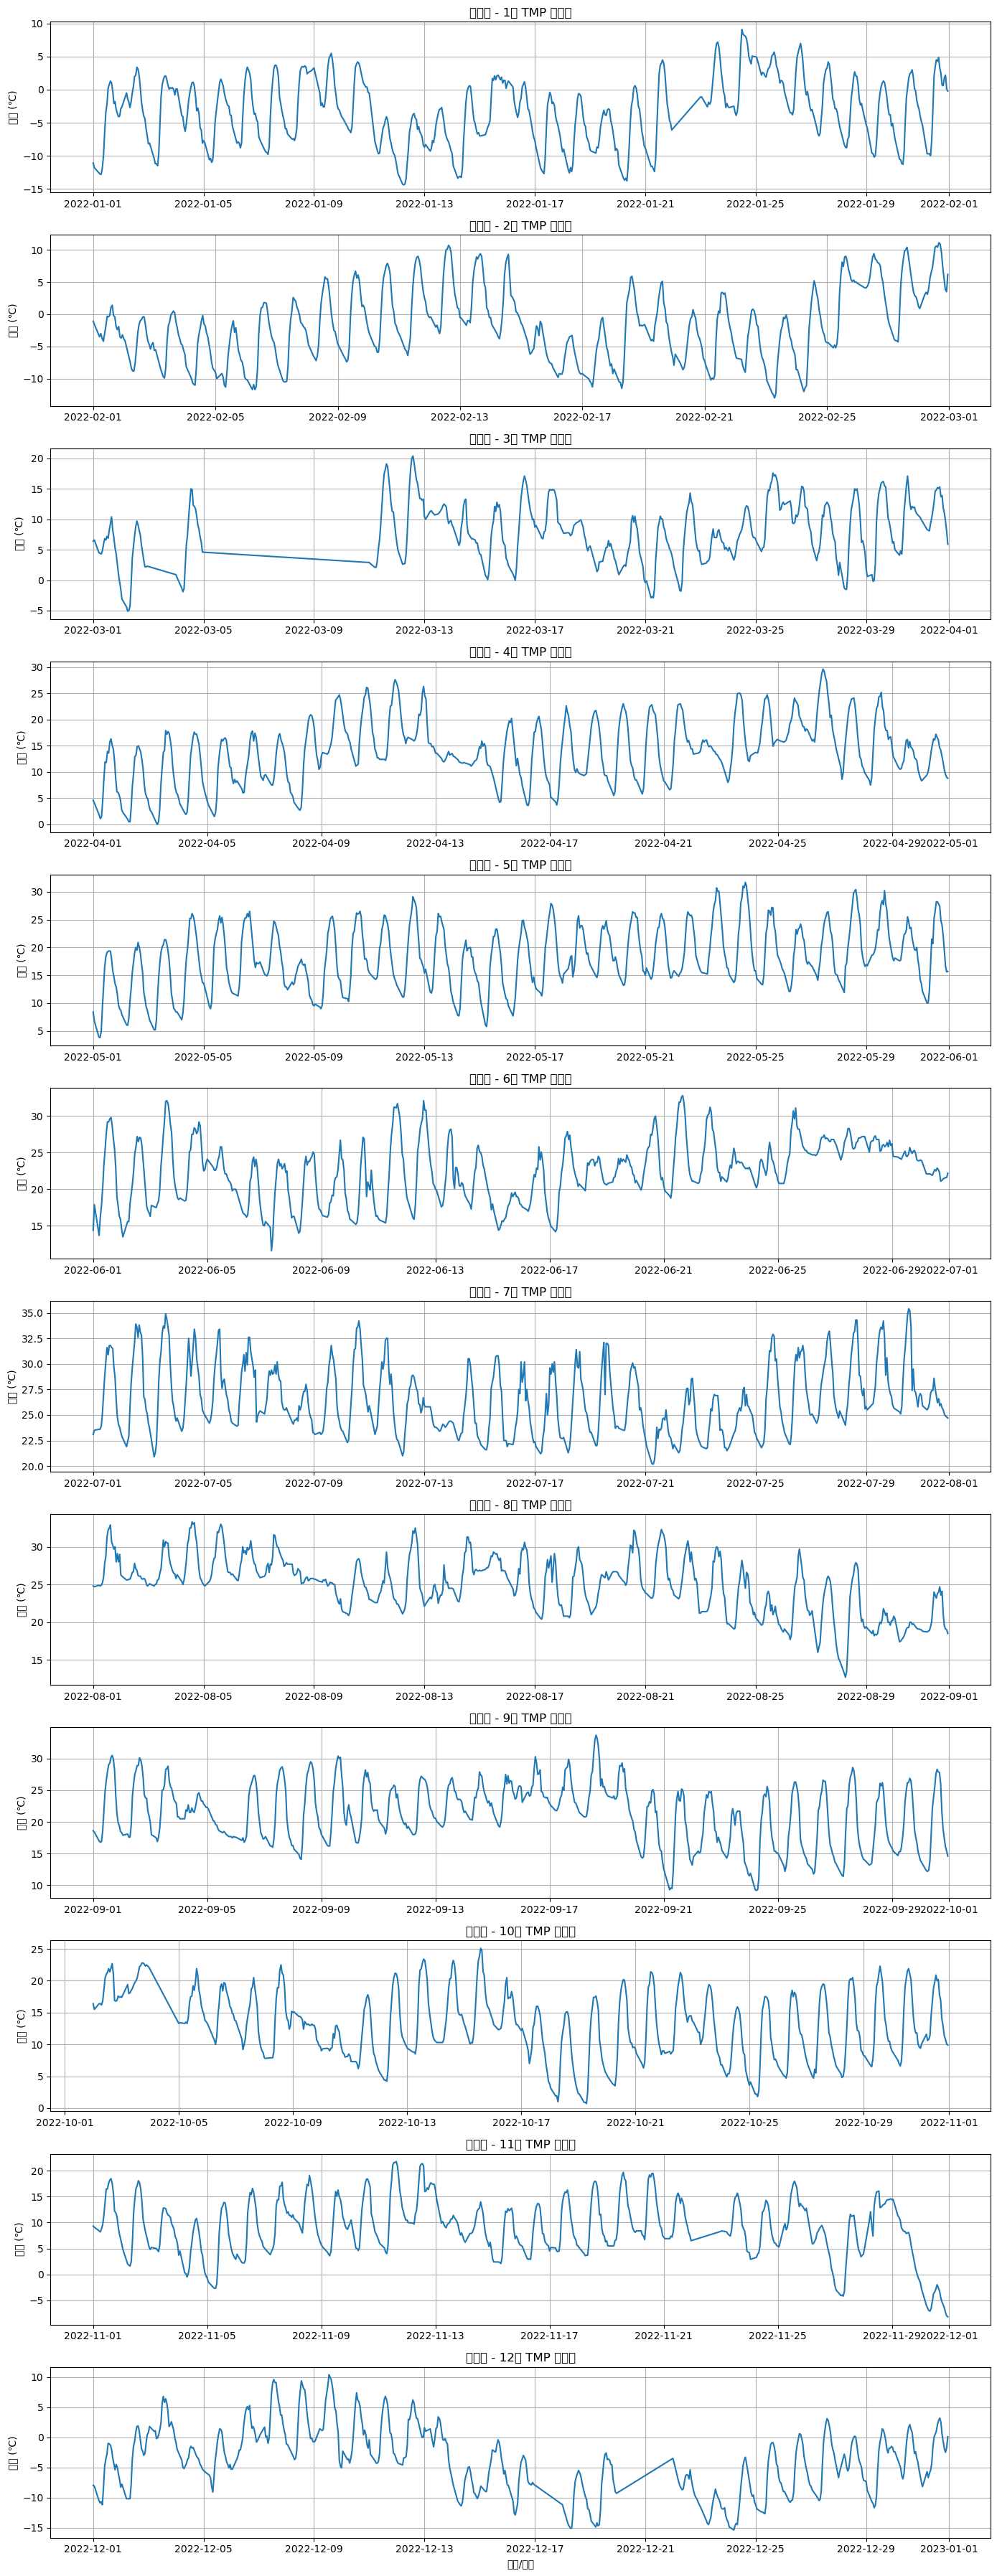

In [122]:
import matplotlib.pyplot as plt

# 1. 대상 역 설정
target_station = '연신내'  # 원하는 역명으로 변경 가능

# 2. 데이터 필터링 및 정렬
station_df = subway_2022[subway_2022['station_name'] == target_station].copy()
station_df['datetime'] = pd.to_datetime(station_df[['year', 'month', 'day', 'hour']])
station_df = station_df.sort_values('datetime')

# 3. 월별 그룹
grouped = station_df.groupby('month')

# 4. 선만 있는 TMP 시계열 서브플롯
n_months = station_df['month'].nunique()
fig, axes = plt.subplots(n_months, 1, figsize=(14, 3 * n_months), sharex=False)

for i, (month, group) in enumerate(grouped):
    ax = axes[i] if n_months > 1 else axes
    ax.plot(group['datetime'], group['TMP'], linestyle='-', color='tab:blue')  # 선만 그리기
    ax.set_title(f'{target_station} - {month}월 TMP 시계열')
    ax.set_ylabel('기온 (℃)')
    ax.grid(True)

plt.xlabel('날짜/시간')
plt.tight_layout()
plt.show()